## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import keras
import itertools
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras.regularizers import l1
import matplotlib.pyplot as plt
from keras import optimizers
%matplotlib inline
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],Regu_rate=1e-4,drp_ratio=0.2):
    
    model = Sequential()
    model.add(Dense(units = input_shape[1] ,input_dim = input_shape[1], kernel_initializer = 'normal', activation = 'relu',name = 'input'))
    
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units, kernel_initializer='normal', activation='relu',name="hidden_layer"+str(i+1), kernel_regularizer=l1(Regu_rate)))  
        model.add(Dropout(drp_ratio))  
        model.add(BatchNormalization())         
    
    model.add(Dense(units=output_units,kernel_initializer='normal', activation='softmax',name='output'))

    return model

In [6]:
def plot_model_score(results):
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    plt.figure(figsize=(10,8))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label='valid-'+cond, color=color_bar[i])
    plt.title("Loss")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


    plt.figure(figsize=(10,8))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label='valid-'+cond, color=color_bar[i])
    plt.title("Accuracy")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [7]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
L1_EXP = 1e-2
Dropout_EXP = [0.2,0.6]

In [12]:
results = {}

for drop_rate in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape,Regu_rate=L1_EXP,drp_ratio=drop_rate)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "dropout-%s" % str(drop_rate)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

Epoch 47/50
50000/50000 [==============================] - 67s 1ms/step - loss: 2.1472 - acc: 0.3903 - val_loss: 2.1991 - val_acc: 0.3639
Epoch 48/50
50000/50000 [==============================] - 74s 1ms/step - loss: 2.1503 - acc: 0.3911 - val_loss: 2.1785 - val_acc: 0.3995
Epoch 49/50
50000/50000 [==============================] - 67s 1ms/step - loss: 2.1502 - acc: 0.3899 - val_loss: 2.1279 - val_acc: 0.4156
Epoch 50/50
50000/50000 [==============================] - 68s 1ms/step - loss: 2.1402 - acc: 0.3945 - val_loss: 2.1921 - val_acc: 0.3785
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)            

Epoch 43/50
50000/50000 [==============================] - 68s 1ms/step - loss: 2.4128 - acc: 0.2262 - val_loss: 2.3468 - val_acc: 0.2666
Epoch 44/50
50000/50000 [==============================] - 68s 1ms/step - loss: 2.4107 - acc: 0.2241 - val_loss: 2.3564 - val_acc: 0.2464
Epoch 45/50
50000/50000 [==============================] - 68s 1ms/step - loss: 2.4061 - acc: 0.2266 - val_loss: 2.4102 - val_acc: 0.2166
Epoch 46/50
50000/50000 [==============================] - 68s 1ms/step - loss: 2.4000 - acc: 0.2267 - val_loss: 2.3355 - val_acc: 0.2448
Epoch 47/50
50000/50000 [==============================] - 68s 1ms/step - loss: 2.3859 - acc: 0.2298 - val_loss: 2.3364 - val_acc: 0.2506
Epoch 48/50
50000/50000 [==============================] - 68s 1ms/step - loss: 2.3894 - acc: 0.2308 - val_loss: 2.3207 - val_acc: 0.2599
Epoch 49/50
50000/50000 [==============================] - 68s 1ms/step - loss: 2.3845 - acc: 0.2276 - val_loss: 2.3706 - val_acc: 0.2522
Epoch 50/50
50000/50000 [=========

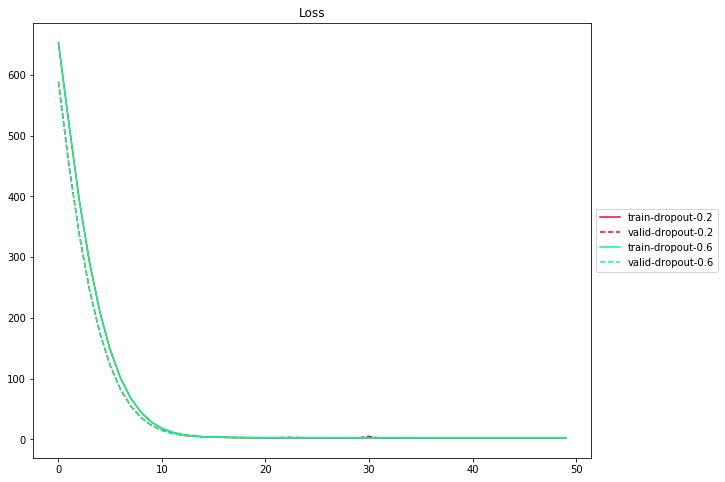

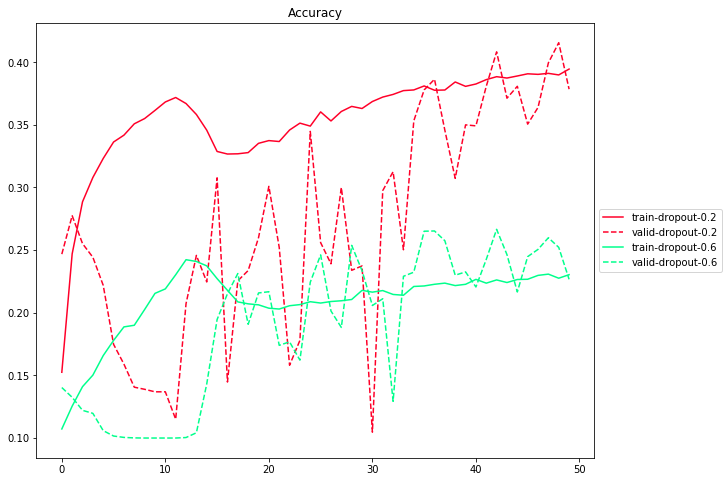

'\nPlot results\n'

In [13]:
plot_model_score(results)
"""
Plot results
"""